In [24]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import wandb


In [25]:
# Login WandB
try:
    wandb.login()
    print("W&B login successful!")
except Exception as e:
    print(f"W&B login info: {e}")
    print("If needed, run: wandb login")

W&B login successful!



In [26]:
# Data loading - Updated batch size for avid-sweep-3
img_height = 180
img_width = 180
batch_size = 8  # Updated to match avid-sweep-3

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=42,  # Fixed seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=42,  # Same seed to ensure no overlap
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 2054 files belonging to 4 classes.
Using 1644 files for training.
Using 1644 files for training.
Found 2054 files belonging to 4 classes.
Found 2054 files belonging to 4 classes.
Using 410 files for validation.
Using 410 files for validation.


In [27]:
# Class names and setup preprocessing
class_names = train_ds.class_names
print("Classes détectées :", class_names)
print(f"Number of classes: {len(class_names)}")

# Data augmentation to avoid overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),  
    tf.keras.layers.RandomZoom(0.1),
])

# Apply preprocessing - FIXED: Apply augmentation only to training
def preprocess_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)
    return image, label

def preprocess_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply different preprocessing to train and validation
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

# Performance optimization - FIXED: Remove cache to prevent data leakage
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Classes détectées : ['Apple', 'Banana', 'Carrot', 'Coconut']
Number of classes: 4
 ['Apple', 'Banana', 'Carrot', 'Coconut']
Number of classes: 4


In [28]:
# Fresh model creation - avid-sweep-3 configuration
import os

if os.path.exists("model1.keras"):
    os.remove("model1.keras")
    print("Deleted old model file")

num_classes = len(class_names)

# Updated model with avid-sweep-3 parameters: MUCH smaller and more trustworthy
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    
    # First block - 4 filters (very small)
    tf.keras.layers.Conv2D(4, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    # Second block - 16 filters
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    # Third block - 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    # Flatten and dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.382),  # Updated dropout rate from avid-sweep-3
    tf.keras.layers.Dense(128, activation='relu'),  # Layer size from avid-sweep-3
    tf.keras.layers.Dropout(0.382),  # Consistent dropout
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile with RMSprop optimizer and avid-sweep-3 learning rate
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0010184874268065862),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Deleted old model file



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 180, 180, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 90, 90, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,988,452 (7.59 MB)

 Trainable params: 1,988,452 (7.59 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Cell 5
# Training with callbacks - removed adaptive learning rate
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Reduced patience
    restore_best_weights=True,
    verbose=1
)

# Train with fixed learning rate
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  
    callbacks=[early_stopping],  
    verbose=1
)


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 12:44 4s/step - accuracy: 0.2500 - loss: 1.3482 ━━━━━━━━━━━━━━━━━━━━ 12:44 4s/step - accuracy: 0.2500 - loss: 1.34 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.3125 - loss: 2.793 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.3125 - loss: 2.7933 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.3212 - loss: 3.046 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.3212 - loss: 3.046 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3149 - loss: 2.971 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3149 - loss: 2.971 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3136 - loss: 2.854 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3136 - loss: 2.854 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3117 - loss: 2.744 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.3117 - loss: 2.744 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.3114 - loss: 2.646 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.3114 - loss: 2.646 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accu

In [30]:
# Cell 6
# Save the model
model.save("model1.keras")
print("Model saved successfully!")


Model saved successfully!



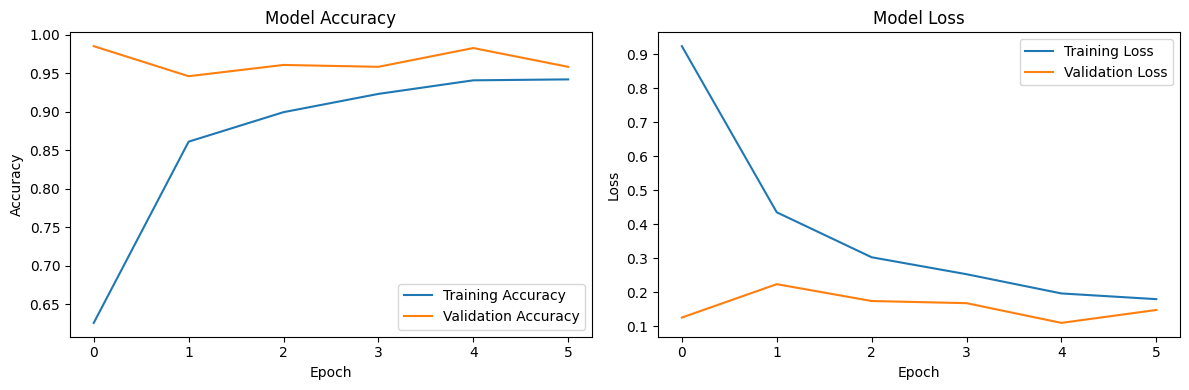

Best validation accuracy: 98.54%



In [86]:
# Cell 7
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print final validation accuracy
final_val_acc = max(history.history['val_accuracy'])
print(f"Best validation accuracy: {final_val_acc*100:.2f}%")


# W&B Sweep

Now we'll implement a sweep to find the best hyperparameters for our model using Weights & Biases.

In [40]:
# Step 1: Define sweep configuration
sweep_config = {
    'method': 'random',  # search method: 'grid', 'random', or 'bayes'
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},  # what to optimize
    'parameters': {
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 0.0001,
            'max': 0.01
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'fc_layer_size': {
            'values': [64, 128, 256, 512]
        },
        'dropout_rate': {
            'distribution': 'uniform',
            'min': 0.3,
            'max': 0.7
        },
        'conv_filters': {
            'values': [[8, 16, 32, 64], [64, 32, 16, 8], [24, 24, 24, 24]]
        },
        'optimizer': {
            'values': ['adam', 'rmsprop']
        },
        'epochs': {'value': 20}  # fixed for faster experimentation
    }
}

print("Sweep configuration:")
import pprint
pprint.pprint(sweep_config)

Sweep configuration:
{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'batch_size': {'values': [16, 32, 64]},
                'conv_filters': {'values': [[8, 16, 32, 64],
                                            [64, 32, 16, 8],
                                            [24, 24, 24, 24]]},
                'dropout_rate': {'distribution': 'uniform',
                                 'max': 0.7,
                                 'min': 0.3},
                'epochs': {'value': 20},
                'fc_layer_size': {'values': [64, 128, 256, 512]},
                'learning_rate': {'distribution': 'log_uniform_values',
                                  'max': 0.01,
                                  'min': 0.0001},
                'optimizer': {'values': ['adam', 'rmsprop']}}}


In [41]:
# Step 2: Initialize the sweep
sweep_id = wandb.sweep(sweep=sweep_config, project="cnn-image-classifier")
print(f"Sweep ID: {sweep_id}")

Create sweep with ID: hve5mnmw
Sweep URL: https://wandb.ai/mokiii-epsi/cnn-image-classifier/sweeps/hve5mnmw
Sweep ID: hve5mnmw


In [42]:
# Step 3: Define training function for sweep
def train_sweep():
    # Initialize wandb run
    wandb.init()
    config = wandb.config
    
    print(f"Training with config: {dict(config)}")
    
    # Create datasets with the sweep batch size
    train_ds_sweep = tf.keras.utils.image_dataset_from_directory(
        "dataset",
        validation_split=0.3,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=config.batch_size,
        shuffle=True
    )

    val_ds_sweep = tf.keras.utils.image_dataset_from_directory(
        "dataset",
        validation_split=0.3,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=config.batch_size,
        shuffle=False
    )
    
    # Apply preprocessing
    train_ds_sweep = train_ds_sweep.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_sweep = val_ds_sweep.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Optimize performance
    train_ds_sweep = train_ds_sweep.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds_sweep = val_ds_sweep.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Build model with sweep parameters
    filters = config.conv_filters
    model_sweep = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(img_height, img_width, 3)),
        
        # Dynamic convolutional layers based on config
        tf.keras.layers.Conv2D(filters[0], (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        
        tf.keras.layers.Conv2D(filters[1], (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        
        tf.keras.layers.Conv2D(filters[2], (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(filters[3], (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2)),
        
        # Flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(config.dropout_rate),
        tf.keras.layers.Dense(config.fc_layer_size, activation='relu'),
        tf.keras.layers.Dropout(config.dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # FIXED: Proper optimizer configuration
    if config.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    else:  # rmsprop
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=config.learning_rate)
    
    # Compile model with sweep parameters
    model_sweep.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stopping_sweep = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    # Custom callback to log metrics to W&B (avoiding deprecated WandbCallback)
    class WandbMetricsLogger(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs:
                wandb.log({
                    'epoch': epoch,
                    'train_accuracy': logs.get('accuracy', 0),
                    'train_loss': logs.get('loss', 0),
                    'val_accuracy': logs.get('val_accuracy', 0),
                    'val_loss': logs.get('val_loss', 0)
                })
    
    # Train model
    history_sweep = model_sweep.fit(
        train_ds_sweep,
        validation_data=val_ds_sweep,
        epochs=config.epochs,
        callbacks=[
            early_stopping_sweep,
            WandbMetricsLogger()  # Use custom logger instead of deprecated WandbCallback
        ],
        verbose=1
    )
    
    # Log final metrics
    final_val_accuracy = max(history_sweep.history['val_accuracy'])
    final_val_loss = min(history_sweep.history['val_loss'])
    
    wandb.log({
        'final_val_accuracy': final_val_accuracy,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final validation accuracy: {final_val_accuracy:.4f}")
    
    wandb.finish()

print("Training function defined successfully!")

Training function defined successfully!


In [43]:
# Clear any previous W&B runs and create a fresh sweep
import os
if 'sweep_id' in locals():
    print(f"Previous sweep ID was: {sweep_id}")

# Initialize a new sweep (since the previous one failed)
print("Creating a new sweep with fixed configuration...")
sweep_id_fixed = wandb.sweep(sweep=sweep_config, project="cnn-image-classifier")
print(f"New Sweep ID: {sweep_id_fixed}")

# Store the new sweep_id
sweep_id = sweep_id_fixed

Previous sweep ID was: hve5mnmw
Creating a new sweep with fixed configuration...
Create sweep with ID: qrxtqkiy
Sweep URL: https://wandb.ai/mokiii-epsi/cnn-image-classifier/sweeps/qrxtqkiy
New Sweep ID: qrxtqkiy


In [44]:
# Step 4: Launch the fixed sweep agent
print("Starting fixed hyperparameter sweep...")
print("This will run multiple training experiments with different hyperparameter combinations")
print("You can monitor progress at: https://wandb.ai/")
print(f"Using sweep ID: {sweep_id}")

# Run 5 different hyperparameter combinations (reduced for testing)
try:
    wandb.agent(sweep_id, function=train_sweep, count=5)
    print("Sweep completed successfully!")
except Exception as e:
    print(f"Sweep encountered an error: {e}")
    print("You can still check partial results at W&B dashboard")

Starting fixed hyperparameter sweep...
This will run multiple training experiments with different hyperparameter combinations
You can monitor progress at: https://wandb.ai/
Using sweep ID: qrxtqkiy


wandb: Agent Starting Run: hblr3hg1 with config:
wandb: 	batch_size: 16
wandb: 	conv_filters: [8, 16, 32, 64]
wandb: 	dropout_rate: 0.46402172340174097
wandb: 	epochs: 20
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0002947559511082836
wandb: 	optimizer: adam


Training with config: {'batch_size': 16, 'conv_filters': [8, 16, 32, 64], 'dropout_rate': 0.46402172340174097, 'epochs': 20, 'fc_layer_size': 128, 'learning_rate': 0.0002947559511082836, 'optimizer': 'adam'}
Found 2054 files belonging to 4 classes.
Using 1438 files for training.
Found 2054 files belonging to 4 classes.
Using 616 files for validation.
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6:32 4s/step - accuracy: 0.0625 - loss: 1.443 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.1406 - loss: 1.448 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.1701 - loss: 1.443 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.1745 - loss: 1.44 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.1746 - loss: 1.4422 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.1750 - loss: 1.441 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.1793 - loss: 1.440 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.1843 - loss: 1.439 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.1885 - loss: 1.437 ━━━━━━━━━━━━━━━━━━━━ 7s

epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
train_accuracy,▁▅▆▇██████
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▂▆▁██▇▇█▇█
val_loss,█▄█▂▁▂▂▁▂▁
epoch,9
final_val_accuracy,0.97727
final_val_loss,0.09599
train_accuracy,0.94019


wandb: Agent Starting Run: 9l26om2q with config:
wandb: 	batch_size: 64
wandb: 	conv_filters: [24, 24, 24, 24]
wandb: 	dropout_rate: 0.6629150840068323
wandb: 	epochs: 20
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.00010665916695677245
wandb: 	optimizer: adam


Training with config: {'batch_size': 64, 'conv_filters': [24, 24, 24, 24], 'dropout_rate': 0.6629150840068323, 'epochs': 20, 'fc_layer_size': 512, 'learning_rate': 0.00010665916695677245, 'optimizer': 'adam'}
Found 2054 files belonging to 4 classes.
Using 1438 files for training.
Found 2054 files belonging to 4 classes.
Using 616 files for validation.
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1:27 4s/step - accuracy: 0.2031 - loss: 1.440 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.1992 - loss: 1.44 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 0.2040 - loss: 1.43 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - accuracy: 0.2048 - loss: 1.43 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - accuracy: 0.2063 - loss: 1.43 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.2084 - loss: 1.43 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.2115 - loss: 1.43 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.2140 - loss: 1.42 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.2171 - loss: 1.42 ━━━━━━━━━━━━━━━━━━━━ 4s 31

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
final_val_accuracy,▁
final_val_loss,▁
train_accuracy,▁▂▃▄▅▆▆▇▇▇███
train_loss,██▇▆▅▄▃▃▂▂▂▁▁
val_accuracy,▁▁▂▃▅█▇██████
val_loss,██▇▆▅▂▃▁▁▁▁▁▁
epoch,12
final_val_accuracy,0.93506
final_val_loss,0.27909
train_accuracy,0.79346


wandb: Agent Starting Run: atnrz0o0 with config:
wandb: 	batch_size: 32
wandb: 	conv_filters: [8, 16, 32, 64]
wandb: 	dropout_rate: 0.3989152505965143
wandb: 	epochs: 20
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.000648108648768623
wandb: 	optimizer: rmsprop


Training with config: {'batch_size': 32, 'conv_filters': [8, 16, 32, 64], 'dropout_rate': 0.3989152505965143, 'epochs': 20, 'fc_layer_size': 256, 'learning_rate': 0.000648108648768623, 'optimizer': 'rmsprop'}
Found 2054 files belonging to 4 classes.
Using 1438 files for training.
Found 2054 files belonging to 4 classes.
Using 616 files for validation.
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3:00 4s/step - accuracy: 0.2812 - loss: 1.390 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.2656 - loss: 1.41 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.2569 - loss: 1.41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.2572 - loss: 1.41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.2620 - loss: 1.41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.2721 - loss: 1.40 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.2830 - loss: 1.40 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.2921 - loss: 1.39 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.2986 - loss: 1.39 ━━━━━━━━━━━━━━━━━━━━ 4s 12

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
final_val_accuracy,▁
final_val_loss,▁
train_accuracy,▁▄▅▆▆▇▇▇███████
train_loss,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▇▅▇█▇▃█▇██▄▇██
val_loss,█▄▅▃▂▃▅▁▃▁▂▅▂▂▁
epoch,14
final_val_accuracy,0.98864
final_val_loss,0.04134
train_accuracy,0.94019


wandb: Agent Starting Run: nr0w7cyn with config:
wandb: 	batch_size: 16
wandb: 	conv_filters: [24, 24, 24, 24]
wandb: 	dropout_rate: 0.3528493053828972
wandb: 	epochs: 20
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.001397906449649352
wandb: 	optimizer: adam


Training with config: {'batch_size': 16, 'conv_filters': [24, 24, 24, 24], 'dropout_rate': 0.3528493053828972, 'epochs': 20, 'fc_layer_size': 128, 'learning_rate': 0.001397906449649352, 'optimizer': 'adam'}
Found 2054 files belonging to 4 classes.
Using 1438 files for training.
Found 2054 files belonging to 4 classes.
Using 616 files for validation.
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6:04 4s/step - accuracy: 0.2500 - loss: 1.385 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.2500 - loss: 1.39 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.2569 - loss: 1.38 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.2591 - loss: 1.39 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.2598 - loss: 1.39 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.2582 - loss: 1.40 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.2570 - loss: 1.40 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.2551 - loss: 1.40 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.2546 - loss: 1.40 ━━━━━━━━━━━━━━━━━━━━ 8s 105m

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_val_accuracy,▁
final_val_loss,▁
train_accuracy,▁▄▆▇▇▇██▇███████████
train_loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▇▇█▁▃███▆██▇▇██████
val_loss,▄▃▂▂██▁▂▂▃▁▁▂▂▁▁▁▁▁▁
epoch,19
final_val_accuracy,0.98539
final_val_loss,0.06058
train_accuracy,0.95758


wandb: Agent Starting Run: 4gkwdidh with config:
wandb: 	batch_size: 64
wandb: 	conv_filters: [64, 32, 16, 8]
wandb: 	dropout_rate: 0.6477339585004396
wandb: 	epochs: 20
wandb: 	fc_layer_size: 64
wandb: 	learning_rate: 0.004872065915047665
wandb: 	optimizer: rmsprop


Training with config: {'batch_size': 64, 'conv_filters': [64, 32, 16, 8], 'dropout_rate': 0.6477339585004396, 'epochs': 20, 'fc_layer_size': 64, 'learning_rate': 0.004872065915047665, 'optimizer': 'rmsprop'}
Found 2054 files belonging to 4 classes.
Using 1438 files for training.
Found 2054 files belonging to 4 classes.
Using 616 files for validation.
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - accuracy: 0.2188 - loss: 1.423 ━━━━━━━━━━━━━━━━━━━━ 20s 980ms/step - accuracy: 0.2344 - loss: 2.003 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2361 - loss: 2.2038  ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2347 - loss: 2.23 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2353 - loss: 2.22 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2395 - loss: 2.18 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2422 - loss: 2.15 ━━━━━━━━━━━━━━━━━━━━ 14s 991ms/step - accuracy: 0.2452 - loss: 2.115 ━━━━━━━━━━━━━━━━━━━━ 13s 974ms/step - accuracy: 0.2472 - loss: 2.082 ━━━━━━━━━━━━━━━━━━━━ 12s 964

epoch,▁▂▂▃▄▄▅▅▆▇▇█
final_val_accuracy,▁
final_val_loss,▁
train_accuracy,▁▁▂▅▅▆▆▅▆▇▇█
train_loss,█▆▆▄▃▂▃▂▂▁▁▁
val_accuracy,▂▂▇▂█▇█▃▂▂▁▂
val_loss,▅▅▅█▂▃▂▃▁▁▂▁
epoch,11
final_val_accuracy,0.93831
final_val_loss,0.81631
train_accuracy,0.59527


Sweep completed successfully!


In [ ]:
# Alternative: Run a smaller test sweep first
# Uncomment and run this cell instead if you want to test with fewer runs

# print("Running test sweep with 3 trials...")
# wandb.agent(sweep_id, function=train_sweep, count=3)

In [ ]:
# Step 5: Analyze sweep results
def analyze_sweep_results(sweep_id):
    """
    Function to analyze and visualize sweep results
    """
    api = wandb.Api()
    sweep = api.sweep(f"cnn-image-classifier/{sweep_id}")
    
    results = []
    for run in sweep.runs:
        # Get run config and summary
        config = run.config
        summary = run.summary
        
        if 'final_val_accuracy' in summary:
            results.append({
                'run_name': run.name,
                'val_accuracy': summary['final_val_accuracy'],
                'val_loss': summary.get('final_val_loss', None),
                'learning_rate': config.get('learning_rate', None),
                'batch_size': config.get('batch_size', None),
                'fc_layer_size': config.get('fc_layer_size', None),
                'dropout_rate': config.get('dropout_rate', None),
                'optimizer': config.get('optimizer', None),
                'conv_filters': str(config.get('conv_filters', None))
            })
    
    # Convert to DataFrame for analysis
    import pandas as pd
    df = pd.DataFrame(results)
    
    if len(df) > 0:
        # Sort by validation accuracy
        df_sorted = df.sort_values('val_accuracy', ascending=False)
        
        print("Top 5 performing configurations:")
        print(df_sorted.head())
        
        # Best configuration
        best_config = df_sorted.iloc[0]
        print(f"\nBest configuration:")
        print(f"Validation Accuracy: {best_config['val_accuracy']:.4f}")
        print(f"Learning Rate: {best_config['learning_rate']}")
        print(f"Batch Size: {best_config['batch_size']}")
        print(f"FC Layer Size: {best_config['fc_layer_size']}")
        print(f"Dropout Rate: {best_config['dropout_rate']}")
        print(f"Optimizer: {best_config['optimizer']}")
        print(f"Conv Filters: {best_config['conv_filters']}")
        
        return df_sorted
    else:
        print("No results found. Make sure the sweep has completed some runs.")
        return None

print("Analysis function defined. Run this after your sweep completes:")

Analysis function defined. Run this after your sweep completes:



## How to Use the Sweep

1. **Run Cell 8**: Define the sweep configuration
2. **Run Cell 9**: Initialize the sweep and get the sweep ID
3. **Run Cell 10**: Define the training function that will be called for each hyperparameter combination
4. **Run Cell 11**: Launch the sweep agent (this will take some time as it runs multiple experiments)
5. **Run Cell 13**: After the sweep completes, analyze the results to find the best hyperparameters

## What the Sweep Will Optimize

- **Learning Rate**: From 0.0001 to 0.01
- **Batch Size**: 16, 32, or 64
- **FC Layer Size**: 64, 128, 256, or 512 neurons
- **Dropout Rate**: From 0.3 to 0.7
- **Convolutional Filters**: Different filter configurations
- **Optimizer**: Adam or RMSprop

The sweep will try 10 different combinations and track the validation accuracy to find the best performing model.

# Model Validation & Diagnostics

Let's add some diagnostic checks to understand if our model performance is realistic or if there are issues.